In [1]:
from functools import reduce
import operator
import math
import matplotlib.pyplot as plt
import random

In [2]:
def sort_clockwise(data):
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), data), [len(data)] * 2))
    data = sorted(data, key=lambda data: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, data, center))[::-1]))) % 360)
    return data

In [3]:
def sub_vec(a, b):
    return (a[0] - b[0], a[1] - b[1])

In [4]:
def prod_vec(a, b):
    return a[0] * b[1] - a[1] * b[0]

In [5]:
def convex(vertex1, vertex2, vertex3):
    if prod_vec(sub_vec(vertex1, vertex2), sub_vec(vertex2, vertex3)) > 0:
        return True
    return False

In [6]:
def is_ear(p1, p2, p3, polygon):
    if contains_no_points(p1, p2, p3, polygon) and convex(p1, p2, p3) and getAngle(p3, p2, p1) <180:
        return True
    return False

In [7]:
def point_in_triangle(point, vertex1, vertex2, vertex3):
        sideAB = convex(point, vertex1, vertex2)
        sideBC = convex(point, vertex2, vertex3)
        sideCA = convex(point, vertex3, vertex1)
        return sideAB == sideBC == sideCA 

In [8]:
def contains_no_points(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif point_in_triangle(pn, p1, p2, p3):
            return False
    return True

In [9]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [10]:
def earclip(poly):
    triangles = []
    ears_angles = {}

    polygon = sort_clockwise(poly)
    polygon.reverse()
  
    point_count = len(polygon)
    for i in range(point_count):
        prev_point = polygon[i - 1]
        point = polygon[i]
        next_point = polygon[(i + 1) % point_count]

        if is_ear(prev_point, point, next_point, polygon):
            ears_angles[point] = getAngle(next_point, point, prev_point)
           
    while ears_angles and point_count >= 3:
        ear = min(ears_angles, key=ears_angles.get)
        del ears_angles[ear]
        i = polygon.index(ear)
        prev_point = polygon[i - 1]
        next_point = polygon[(i + 1) % point_count]

        polygon.remove(ear)
        point_count -= 1
        triangles.append((prev_point, ear, next_point))
        if point_count > 3:
            prev_prev_point = polygon[i - 2]
            next_next_point = polygon[(i + 1) % point_count]

            update = [(prev_prev_point, prev_point, next_point), (prev_point, next_point, next_next_point)]
            for angle in update:
                p1, p2, p3 = angle
                if is_ear(p1, p2, p3, polygon):
                    if p2 not in ears_angles.keys():
                        ears_angles[p2] = getAngle(p3, p2, p1)
                elif p2 in ears_angles.keys():
                    del ears_angles[p2]
    
    return triangles

In [11]:
def draw_polygon(axes, polygon):
    polygon = sort_clockwise(polygon)
    for i in range(len(polygon)):
        vertex = polygon[i]
        next_vertex = polygon[(i + 1) % len(polygon)]
        axes[1].plot([vertex[0],next_vertex[0]],[vertex[1],next_vertex[1]],'o-')

In [12]:
def draw_triangle(axes, triangle):
    a = triangle[0]
    b = triangle[1]
    c = triangle[2]
    axes[0].plot([a[0],b[0]],[a[1],b[1]],'o-')
    axes[0].plot([b[0],c[0]],[b[1],c[1]],'o-')
    axes[0].plot([c[0],a[0]],[c[1],a[1]],'o-')

In [13]:
def draw_triangulation(axes, triangles):
    for triangle in triangles:
        draw_triangle(axes, triangle)

In [14]:
def haveIntersection(t1,t2):
    return len(set(t1) & set(t2)) == 2

def getAnglesSum(t1, t2):
    angle1 = 0
    angle2 = 0
    for i in range(3):
        if t1[i] not in t2:
            tmp = [t1[(i - 1) % 3], t1[(i + 1) % 3]]
            tmp = sort_clockwise(tmp)
            tmp.insert(1,t1[i])
            angle1 = getAngle(tmp[0], tmp[1], tmp[2])
            
            if angle1 > 180:
                tmp.reverse()
                angle1 = getAngle(tmp[0], tmp[1], tmp[2])
            
            break
    
    for i in range(3):
        if t2[i] not in t1:
            tmp = [t2[(i - 1) % 3], t2[(i + 1) % 3]]
            tmp = sort_clockwise(tmp)
            tmp.insert(1,t2[i])
            angle2 = getAngle(tmp[0], tmp[1], tmp[2])
            
            if angle2 > 180:
                tmp.reverse()
                angle2 = getAngle(tmp[0], tmp[1], tmp[2])
                
            break
    
    return angle1 + angle2

def changeDiagonal(t1,t2):
    tmp1 = 0
    tmp2 = 0
    for i in range(3):
        if t1[i] not in t2:
            tmp1 = i
            break
    for i in range(3):
        if t2[i] not in t1:
            tmp2 = i
            break
    
    result1 = [t1[tmp1], t2[tmp2], t2[(tmp2 + 1) % 3]]
    result2 = [t1[tmp1], t2[tmp2], t2[(tmp2 + 2) % 3]]
    
    return result1, result2

def applyFlip(triangles):
    end = False
    while not(end):
        end = True
        for t1, triangle1 in enumerate(triangles):
            for t2, triangle2 in enumerate(triangles):
                if haveIntersection(triangle1, triangle2):
                    angle_sum = getAnglesSum(triangle1, triangle2)

                    if angle_sum > 180:
                        end = False

                        tmp1, tmp2 = changeDiagonal(triangle1, triangle2)
                        triangles[t1] = tmp1
                        triangles[t2] = tmp2
    
    return triangles

In [15]:
def draw(data, with_flip = False):
    triangles = earclip(data)
    
    if with_flip: triangles = applyFlip(triangles)
            
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    draw_triangulation(axes, triangles)
    draw_polygon(axes, data)
    axes[0].axis('off')
    axes[1].axis('off')

In [16]:
STAR = [(350, 250), (350, 75), (379, 161), (469, 161), (397, 215), (423, 301), (277, 301), (303, 215), (231, 161), (321, 161)]

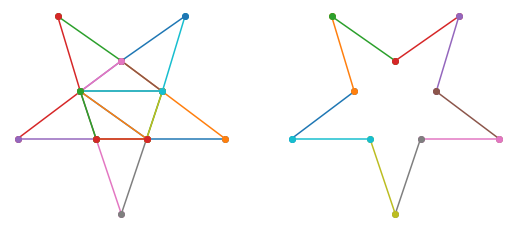

In [17]:
draw(STAR)

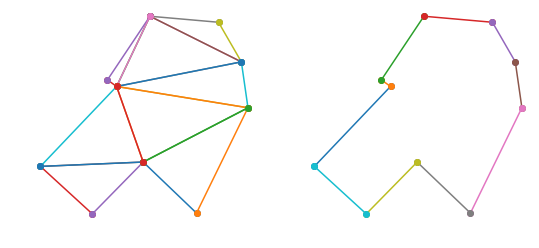

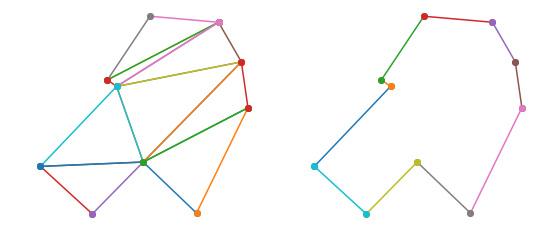

In [200]:
test = list(zip([random.random() for i in range(10)], [random.random() for i in range(10)]))
draw(test, with_flip=True)
draw(test)

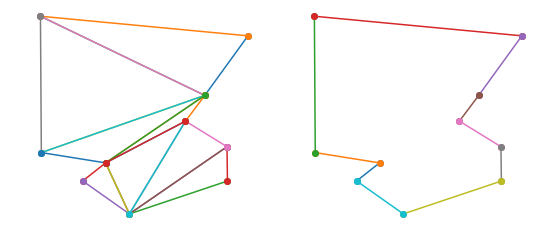

In [196]:
test = list(zip([random.random() for i in range(10)], [random.random() for i in range(10)]))
draw(test)

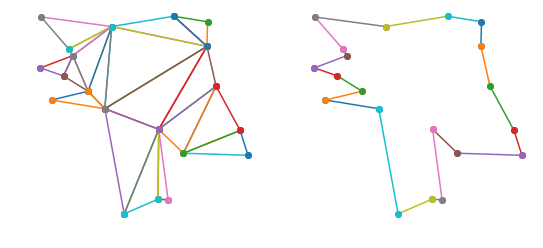

In [197]:
test = list(zip([random.random() for i in range(20)], [random.random() for i in range(20)]))
draw(test, with_flip = True)

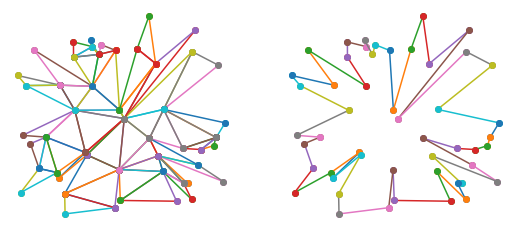

In [20]:
test = list(zip([random.random() for i in range(50)], [random.random() for i in range(50)]))
draw(test, with_flip = True)

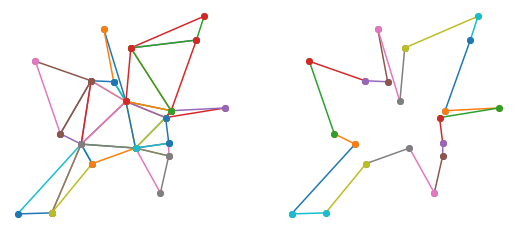

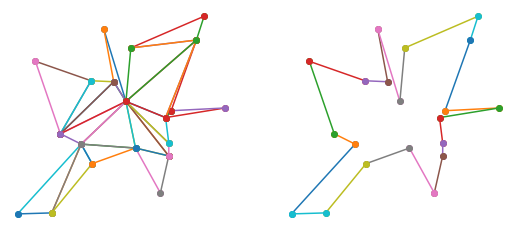

In [20]:
test = list(zip([random.random() for i in range(20)], [random.random() for i in range(20)]))
draw(test, with_flip=True)
draw(test)

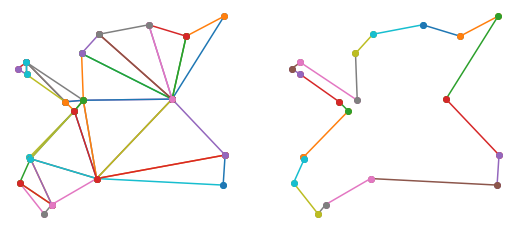

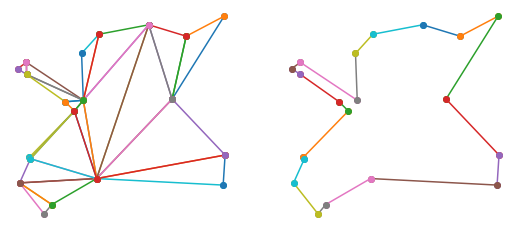

In [21]:
test = list(zip([random.random() for i in range(20)], [random.random() for i in range(20)]))
draw(test, with_flip=True)
draw(test)